# Uncertainty quantification using "DRIVE: Ditifal Retinal Images for Vessel Extraction" dataset
 
__author__: Yongchan Kwon

This note shows an example of the use of the method introduced in the paper "Uncertainty quantification using Bayesian neural networks in classification: Application to biomedical segmentation".

This notebook is based on the Walter de Back's amazing notebook https://tiflab.com/wdeback/dl-keras-tutorial/blob/master/notebooks/3-cnn-segment-retina-uncertainty.ipynb I really recommend to see together. 

**Reference**

- J.J. Staal, M.D. Abramoff, M. Niemeijer, M.A. Viergever, B. van Ginneken, "Ridge based vessel segmentation in color images of the retina", IEEE Transactions on Medical Imaging, 2004, vol. 23, pp. 501-509.


In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import os, glob
os.environ["CUDA_VISIBLE_DEVICES"] = "1"
np.random.seed(20180621)

#from skimage.external import tifffile # read tiff images
# 'skimage.external.tifffile'모듈... 구버전
# 이제는 이렇게 -->
import tifffile


from skimage.io import imread # read gif images
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras import backend as K
import seaborn as sns

from model import *
import utils
import time

import copy

plt.style.use('ggplot')

In [2]:
print('Backend: ', K.backend())
print('Image_data_format: ', K.image_data_format())
N_train = 200

Backend:  tensorflow
Image_data_format:  channels_last


**Fixed data loder**
- Existing data loading codes (https://github.com/ykwon0407/UQ_BNN/tree/master/retina) ... There was a problem in the process of fetching the file names in order.

***** (1) Loading Train data*****

In [38]:
# declaring name list of images & masks
dir_x = ['30_training.tif', '27_training.tif', '37_training.tif', '38_training.tif',
 '22_training.tif', '24_training.tif', '35_training.tif', '40_training.tif',
 '34_training.tif', '21_training.tif', '31_training.tif', '25_training.tif',
 '33_training.tif', '28_training.tif', '26_training.tif', '29_training.tif',
 '36_training.tif', '39_training.tif', '32_training.tif', '23_training.tif']
 
dir_y = ['30_manual1.gif', '27_manual1.gif', '37_manual1.gif', '38_manual1.gif',
 '22_manual1.gif', '24_manual1.gif', '35_manual1.gif', '40_manual1.gif',
 '34_manual1.gif', '21_manual1.gif', '31_manual1.gif', '25_manual1.gif',
 '33_manual1.gif', '28_manual1.gif', '26_manual1.gif', '29_manual1.gif',
 '36_manual1.gif', '39_manual1.gif', '32_manual1.gif', '23_manual1.gif']

In [39]:
# x - image

train_image_list = []
train_image_names = dir_x
train_image_initial_path = 'input/training/images/'
for image in train_image_names:
    train_image_path = os.path.join(train_image_initial_path, image)
    train_img = tifffile.imread(train_image_path)
    train_image_list.append(train_img)

train_image_array = np.array(train_image_list)
print('Image Data: ', np.shape(train_image_array))

Image Data:  (20, 584, 565, 3)


In [48]:
# y - mask

train_mask_list = []
train_mask_names = dir_y
train_mask_initial_path = 'input/training/1st_manual/'
for mask in train_mask_names:
    train_mask_path = os.path.join(train_mask_initial_path, mask)
    train_mask = imread(train_mask_path)
    train_mask_list.append(train_mask)
    
train_mask_array = np.array(train_mask_list)
train_mask_array = train_mask_array.reshape(train_mask_array.shape[0],train_mask_array.shape[1],train_mask_array.shape[2],1)
print('Mask Data : ', np.shape(train_mask_array))

Mask Data :  (20, 584, 565, 1)


***** (2) Loading Test data*****

In [50]:
# declaring name list of images & masks
test_dir_x = ['01_test.tif', '02_test.tif', '03_test.tif', '04_test.tif',
 '05_test.tif', '06_test.tif', '07_test.tif', '08_test.tif',
 '09_test.tif', '10_test.tif', '11_test.tif', '12_test.tif',
 '13_test.tif', '14_test.tif', '15_test.tif', '16_test.tif',
 '17_test.tif', '18_test.tif', '19_test.tif', '20_test.tif']
 
test_dir_y = ['21_manual1.gif', '22_manual1.gif', '23_manual1.gif', '24_manual1.gif',
 '25_manual1.gif', '26_manual1.gif', '27_manual1.gif', '28_manual1.gif',
 '29_manual1.gif', '30_manual1.gif', '31_manual1.gif', '32_manual1.gif',
 '33_manual1.gif', '34_manual1.gif', '35_manual1.gif', '36_manual1.gif',
 '37_manual1.gif', '38_manual1.gif', '39_manual1.gif', '40_manual1.gif']

In [44]:
# x - image

test_image_list = []
test_image_names = test_dir_x
test_image_initial_path = 'input/test/images/'
for image in test_image_names:
    test_image_path = os.path.join(test_image_initial_path, image)
    test_img = tifffile.imread(test_image_path)
    test_image_list.append(test_img)

test_image_array = np.array(test_image_list)
print('Image Data: ', np.shape(test_image_array))

Image Data:  (20, 584, 565, 3)


In [51]:
# y - mask

test_mask_list = []
test_mask_names = test_dir_y
test_mask_initial_path = 'input/test/1st_manual/'
for mask in test_mask_names:
    test_mask_path = os.path.join(test_mask_initial_path, mask)
    test_mask = imread(test_mask_path)
    test_mask_list.append(test_mask)
    
test_mask_array = np.array(test_mask_list)
test_mask_array = test_mask_array.reshape(test_mask_array.shape[0],test_mask_array.shape[1],test_mask_array.shape[2],1)
print('Mask Data : ', np.shape(test_mask_array))

Mask Data :  (20, 584, 565, 1)


**Loaded images-masks set**
- After modifying the code, the image and mask were correctly paired, unlike the results from the existing code.

In [ ]:
for k in range(0,20):
    fig, ((ax1, ax2)) = plt.subplots(1, 2, figsize=(8, 4))
    # 1st axis : image
    ax1.imshow(image_array[k])
    ax1.set_title('Input image')
    # 2nd axis : mask
    ax2.imshow(mask_array[k], cmap='gray')
    ax2.set_title('Aleatoric')

    plt.tight_layout()
    plt.show()

## Preprecossing

In [54]:
x_train = copy.deepcopy(train_image_array)
y_train = copy.deepcopy(train_mask_array)

x_test = copy.deepcopy(test_image_array)
y_test = copy.deepcopy(test_mask_array)

In [55]:

x_train = utils.preprocess(x_train)
x_test = utils.preprocess(x_test)

y_train = utils.preprocess(y_train)
y_test = utils.preprocess(y_test)

min: 0.0, max: 1.0, shape: (20, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 3), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 1), type: float32
min: 0.0, max: 1.0, shape: (20, 584, 565, 1), type: float32


In [56]:
print(np.shape(x_train), np.shape(y_train))
print(np.shape(x_test), np.shape(y_test))

(20, 584, 565, 3) (20, 584, 565, 1)
(20, 584, 565, 3) (20, 584, 565, 1)


In [57]:
X_train, Y_train = utils.get_random_snippets(x_train, y_train, number=N_train, size=(96,96))
X_test, Y_test = utils.get_random_snippets(x_test, y_test, number=1000, size=(96,96))

print('X_train shape: ', X_train.shape)
print('Y_train shape: ', Y_train.shape)
print('X_test shape: ', X_test.shape)
print('Y_test shape: ', Y_test.shape)

X_train shape:  (200, 96, 96, 3)
Y_train shape:  (200, 96, 96, 1)
X_test shape:  (1000, 96, 96, 3)
Y_test shape:  (1000, 96, 96, 1)


- Check the loaded images - masks.

<Figure size 2000x2000 with 0 Axes>

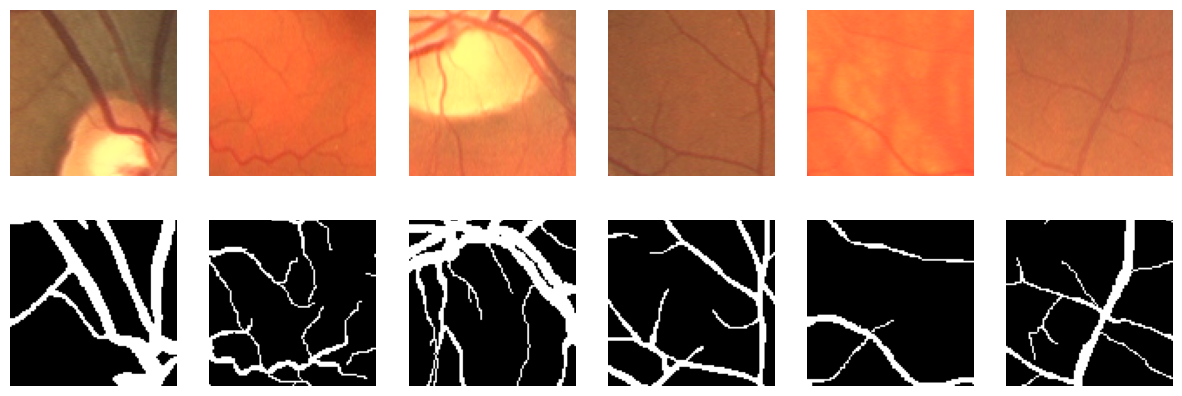

In [58]:
plt.rcParams['figure.figsize'] = [15, 5]
M=6
list_index = np.random.randint(low=0, high=X_train.shape[0], size=M)
plt.figure(figsize=(20,20))
fig, ax = plt.subplots(2,M)
for k, ind in enumerate(list_index):
    ax[0,k].imshow(X_train[ind])
    ax[1,k].imshow(Y_train[ind,:,:,0], cmap='gray')
    
    ax[0,k].axis('off')
    ax[1,k].axis('off')

fig.savefig('./fig/DRIVE_example_200.pdf')

**Model Training - UNet**
- compile

In [99]:
model = UNet(N_filters=32)
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['binary_accuracy', dice_coefficient, precision_smooth, recall_smooth])
print("Number of parameters: ", model.count_params())

Number of parameters:  4452097


- model training

In [100]:
batch_size = 64
epochs = 100 # change : from 'epoch200' -> 50
info_check_string='./weights/DRIVE_stochastic_sample_200.hdf5'
early_stopping=EarlyStopping(monitor='val_loss', patience=40)
model_checkpoint=ModelCheckpoint(info_check_string, monitor='loss', save_best_only=True)

In [101]:
history = model.fit(X_train, Y_train,
                      batch_size=batch_size,
                      epochs=epochs,
                      shuffle=True,
                      verbose=1,
                      validation_split=0.2,
                      callbacks=[early_stopping, model_checkpoint]) 

Epoch 1/100
3/3 [==============================] - 4s 805ms/step - loss: 0.9088 - binary_accuracy: 0.4915 - dice_coefficient: 0.1991 - precision_smooth: 0.1229 - recall_smooth: 0.5247 - val_loss: 4.7418 - val_binary_accuracy: 0.5527 - val_dice_coefficient: 0.1711 - val_precision_smooth: 0.1072 - val_recall_smooth: 0.4240
Epoch 2/100
3/3 [==============================] - 0s 100ms/step - loss: 0.7776 - binary_accuracy: 0.5138 - dice_coefficient: 0.2013 - precision_smooth: 0.1240 - recall_smooth: 0.5370 - val_loss: 29.3752 - val_binary_accuracy: 0.4143 - val_dice_coefficient: 0.1860 - val_precision_smooth: 0.1097 - val_recall_smooth: 0.6133
Epoch 3/100
3/3 [==============================] - 0s 100ms/step - loss: 0.7462 - binary_accuracy: 0.5277 - dice_coefficient: 0.2093 - precision_smooth: 0.1301 - recall_smooth: 0.5372 - val_loss: 48.7317 - val_binary_accuracy: 0.4407 - val_dice_coefficient: 0.1978 - val_precision_smooth: 0.1171 - val_recall_smooth: 0.6367
Epoch 4/100
3/3 [============

- evaluating with the 'test set'

In [113]:
score = model.evaluate(X_test, Y_test, verbose=1)
print('Test loss, acc, dice, precision, recall):', score)

32/32 [==============================] - 1s 22ms/step - loss: 0.9097 - binary_accuracy: 0.8504 - dice_coefficient: 0.1010 - precision_smooth: 0.1445 - recall_smooth: 0.0783
Test loss, acc, dice, precision, recall): [0.9096906781196594, 0.8503811955451965, 0.1010441929101944, 0.14445680379867554, 0.07829629629850388]


- training plot

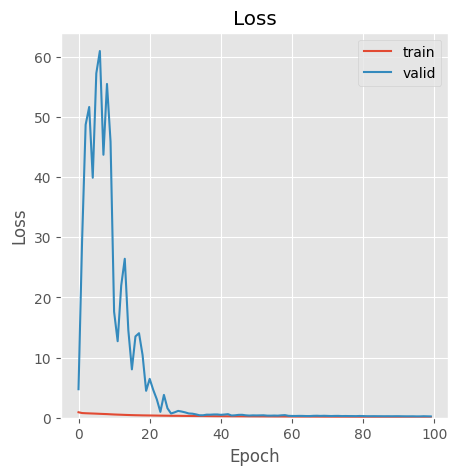

In [112]:
 def plot_history(history, validation=False):
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(5,5), sharex=True)
    #fig.tight_layout()
    # plot history for loss
    ax.plot(history.history['loss'])
    #if validation:
    ax.plot(history.history['val_loss'])
    ax.set_title('Loss')
    ax.set_ylabel('Loss')
    ax.set_ylim(bottom=0.)
    ax.set_xlabel('Epoch')
    ax.legend(['train', 'valid'])
    #ax.set_ylim(0, 0.2)
    plt.savefig('./fig/loss_curve_200.pdf')
    
plot_history(history, validation=True)

# Bayesian neural network: stochastic feed forward

In [114]:
# It takes a time !! 
num = len(X_test)
list_stochastic_feed_forwards = [3,5,10,15,20,30]
result_dict = {}
for ind, num_stochastic_T in enumerate(list_stochastic_feed_forwards):
    start = time.time()
    alea_list = []
    epis_list = []
    dice_list = []
    for i in range(num):
        image = X_test[i]
        gt    = Y_test[i]
        prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=num_stochastic_T)
        alea_list.append(np.mean(aleatoric))
        epis_list.append(np.mean(epistemic))
        dice_list.append(scores[0])
    
    end = time.time()
    print('-'*30)
    print('T: ', num_stochastic_T)
    print('Exec time per prediction = {:.3f}'.format((end-start)/num))
    print('aleatoric: ', np.mean(alea_list), np.std(alea_list))
    print('epistemic: ', np.mean(epis_list), np.std(epis_list))    
    print('Dice: ', np.mean(dice_list), np.std(dice_list))  
    print('-'*30)
    
    result_dict.update({ '{}'.format(str(num_stochastic_T)) : 
    [num_stochastic_T, (end-start)/num,
     np.mean(alea_list), np.std(alea_list),
     np.mean(epis_list), np.std(epis_list),
     np.mean(dice_list), np.std(dice_list)]} )

------------------------------
T:  3
Exec time per prediction = 0.186
aleatoric:  0.018563312 0.004345976
epistemic:  0.001719721 0.0010111093
Dice:  0.8504101560711861 0.07792069727300627
------------------------------
------------------------------
T:  5
Exec time per prediction = 0.279
aleatoric:  0.018556725 0.004335675
epistemic:  0.00205313 0.0011950793
Dice:  0.8504755861163139 0.07783371097747176
------------------------------
------------------------------
T:  10
Exec time per prediction = 0.505
aleatoric:  0.018539894 0.0043420405
epistemic:  0.0023147988 0.0013343544
Dice:  0.8504177520275116 0.07781243924277634
------------------------------
------------------------------
T:  15
Exec time per prediction = 0.741
aleatoric:  0.018544603 0.004344334
epistemic:  0.0024009768 0.0013951648
Dice:  0.8504305557608605 0.07793319298855458
------------------------------
------------------------------
T:  20
Exec time per prediction = 0.968
aleatoric:  0.018547427 0.004341414
epistemic

In [116]:
for i in range(num):
        image = X_test[i]
        gt    = Y_test[i]
        prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=10)#num_stochastic_T)
        alea_list.append(np.mean(aleatoric))
        epis_list.append(np.mean(epistemic))
        dice_list.append(scores[0])

In [117]:
results = np.zeros((5, len(list_stochastic_feed_forwards)))
for ind, num_stochastic_T in enumerate(list_stochastic_feed_forwards):
    results[:, ind] = result_dict[str(num_stochastic_T)][1:6]

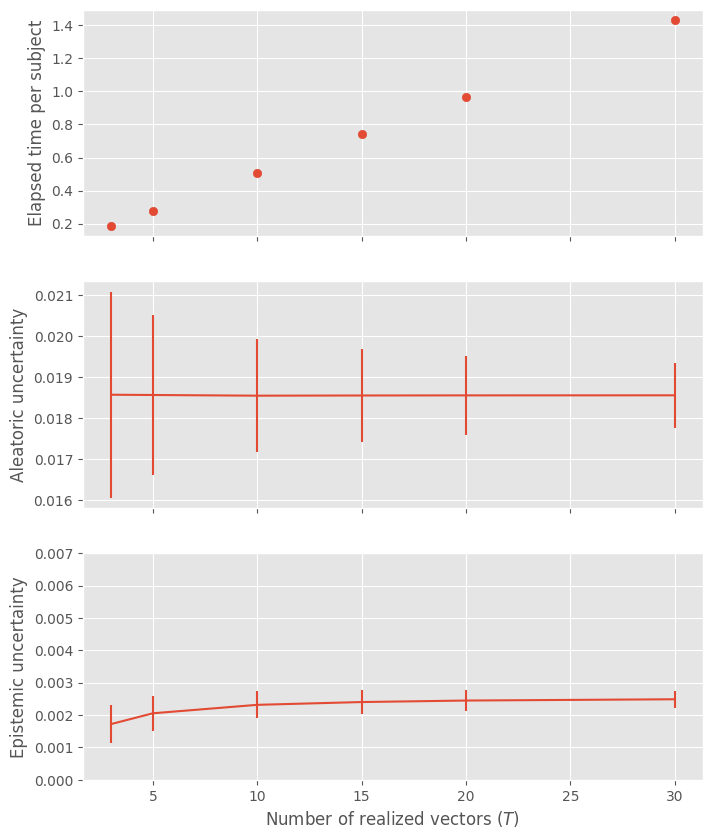

In [118]:
fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(8,10), sharex=True)
# plot history for loss
ax[0].scatter(list_stochastic_feed_forwards,results[0])
ax[0].set_ylabel('Elapsed time per subject')
ax[1].errorbar(list_stochastic_feed_forwards,results[1], yerr=results[2]/np.sqrt(list_stochastic_feed_forwards))
ax[1].set_ylabel('Aleatoric uncertainty')
ax[2].errorbar(list_stochastic_feed_forwards,results[3], yerr=results[4]/np.sqrt(list_stochastic_feed_forwards))
ax[2].set_ylabel('Epistemic uncertainty')
ax[2].set_xlabel('Number of realized vectors ($T$)')
ax[2].set_ylim(0.00,0.007)
plt.savefig('./fig/elapsed_time_vs_feed_200.pdf')

In [119]:
# Case T = 5
num = len(X_test)
start = time.time()
list_alea = []
list_epis = []
for i in range(num):
    image = X_test[i]
    gt    = Y_test[i]
    prediction, aleatoric, epistemic, scores = utils.predict(model, image, gt, T=5)
    list_alea.append(aleatoric.reshape(-1))
    list_epis.append(epistemic.reshape(-1))

end = time.time()
print('Exec time per prediction = {:.3f}'.format((end-start)/num))
print('aleatoric: ', np.mean(list_alea))
print('epistemic: ', np.mean(list_epis))


Exec time per prediction = 0.279
aleatoric:  0.018541059
epistemic:  0.0020604373


In [120]:

list_alea = np.hstack(list_alea)
list_epis = np.hstack(list_epis)

print('aleatoric mean: ', np.mean(list_alea))
print('epistemic mean: ', np.mean(list_epis))

aleatoric mean:  0.018541059
epistemic mean:  0.0020604373


# Bivariate density plot for aleatoric and epistemic uncertainties (Figure 5)

In [121]:
threshold = np.percentile(list_alea, 99)
alea_index = (list_alea > threshold)

/tmp/ipykernel_36204/650148814.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  ax = sns.kdeplot(data, shade = True, color = "gray", cbar=False)


Text(0, 0.5, 'Epistemic')

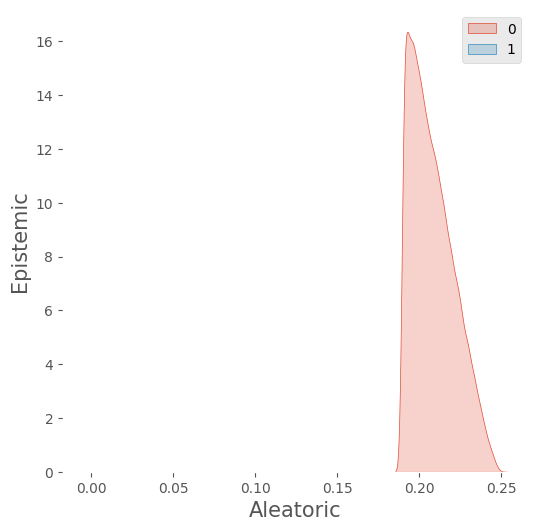

In [123]:
plt.figure(figsize=(6,6))
data = np.vstack([list_alea[alea_index], list_epis[alea_index]]).T
ax = sns.kdeplot(data, shade = True, color = "gray", cbar=False)
ax.patch.set_facecolor('white')
ax.collections[0].set_alpha(0)
ax.set_xlabel('Aleatoric', fontsize = 15)
ax.set_ylabel('Epistemic', fontsize = 15)
#ax.set_xlim(0.15, 0.25)
#ax.set_ylim(0, 0.1)
#plt.savefig('./fig/epis_vs_alea_200.pdf')

## Conditional expectation of epistemic uncertainty (Table 5)

In [124]:
threshold_99 = np.percentile(list_alea, 99.)
threshold_995 = np.percentile(list_alea, 99.5)
threshold_999 = np.percentile(list_alea, 99.9)
threshold_9995 = np.percentile(list_alea, 99.95)
print(threshold_99, threshold_995, threshold_999, threshold_9995)
# alea_index = (list_alea > threshold)

0.18951241731643675 0.2058806877583267 0.227652029246092 0.23324144016206527


- Since aleatoric uncertainty do not disappear no matter how much you increase the number of samples in the data, the Epistemic uncertaining is calculated when the aleatoric is fixed first, as if the type 1 error was fixed first in the statistical hypothesis test

In [125]:
# "Uncertainty quantification using Bayesian neural networks in classification
#   : Application to biomedical image segmentation"...'Table 5'
print('conditional expectation of epistemic')
print("when 0.05 < A < 0.1\n",
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.05) and (list_alea[i] < 0.1)]),
    "\n\nwhen 0.1 < A < 0.15\n",
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.1) and (list_alea[i] < 0.15)]),
    "\n\nwhen 0.15 < A < 0.2\n",
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.15) and (list_alea[i] < 0.2)]),
    "\n\nwhen 0.2 < A < 0.25\n",
    np.mean([list_epis[i] for i in np.arange(len(list_alea)) if (list_alea[i] > 0.2) and (list_alea[i] < 0.25)])
    )

conditional expectation of epistemic
when 0.05 < A < 0.1
 0.010748447 

when 0.1 < A < 0.15
 0.031535544 

when 0.15 < A < 0.2
 0.04025135 

when 0.2 < A < 0.25
 0.024723675


**Visualize Decomposed Uncertainty Maps**
- In addition to the predictions presented through point esimation, the uncertainty map separated into alatoric and epistemic allows us to draw more reliable conclusions.

In [126]:
def display_all(model, X_test, Y_test, i):
    # i = index of image set

    im = X_test[i]
    gt = Y_test[i-1]
    pred, ale, epi, sc = utils.predict(model, im, gt, T=20)


    # 서브플롯 생성
    fig, ((ax1, ax2, ax3, ax4, ax5, ax6)) = plt.subplots(1, 6, figsize=(12, 4))

    # 첫 번째 : 원본
    ax1.imshow(im)
    ax1.set_title('Input image')

    # 두 번째 : Aleatoric
    ax2.imshow(ale)#, cmap='gray')
    ax2.set_title('Aleatoric')

    # 세 번째 : Epistemic
    ax3.imshow(epi)#, cmap='gray')
    ax3.set_title('Epistemic')

    # 네 번째 : Aleatoric + Epistemic
    ax4.imshow(ale+epi)#, cmap='gray')
    ax4.set_title('Aleatoric+Epistemic')

    # 다섯 번째 : Prediction
    ax5.imshow(pred)#, cmap='gray')
    ax5.set_title('Prediction')

    # 다섯 번째 : Ground Truth
    ax6.imshow(gt)#, cmap='gray')
    ax6.set_title('Ground Truth')

    # 서브플롯 간격 조정 및 표시
    plt.tight_layout()
    plt.show()

In [ ]:
print(X_test.shape)
print(Y_test.shape)

(1000, 96, 96, 3)
(1000, 96, 96, 1)


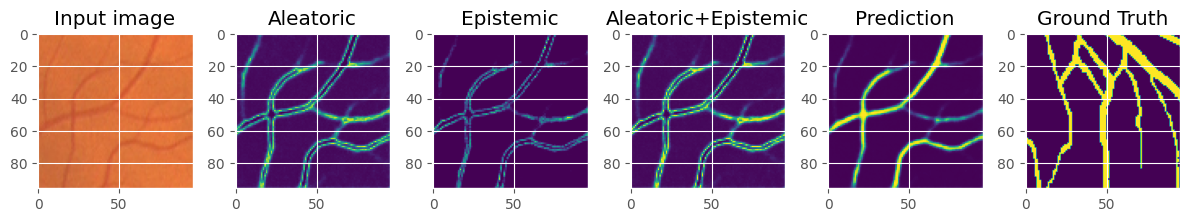

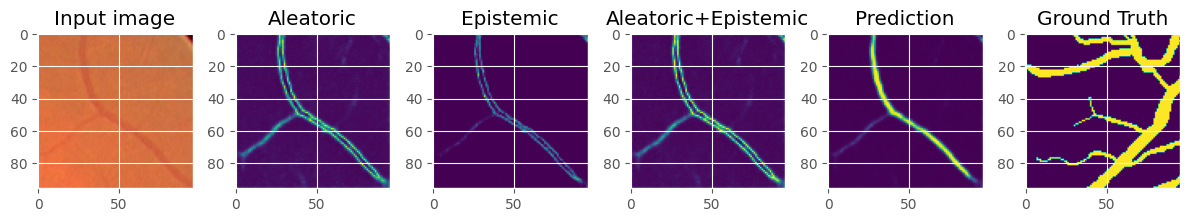

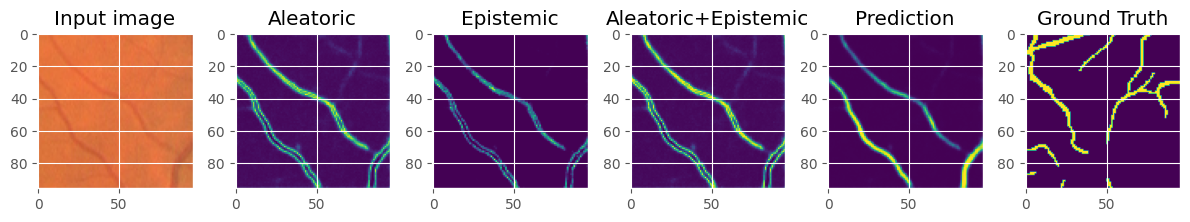

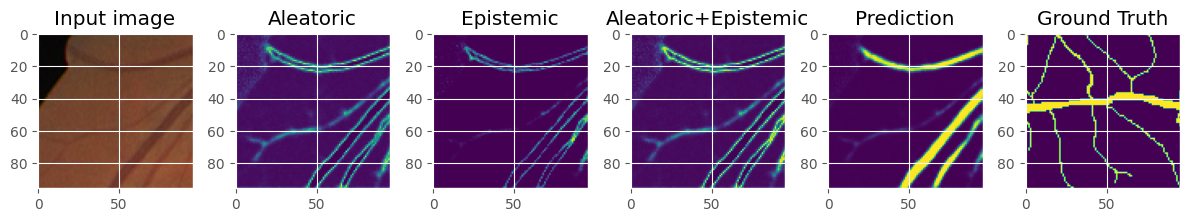

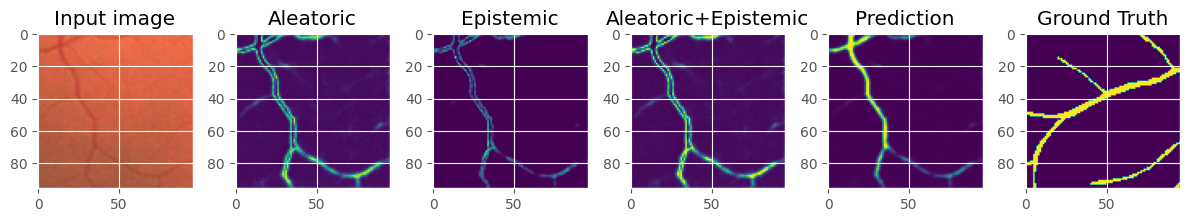

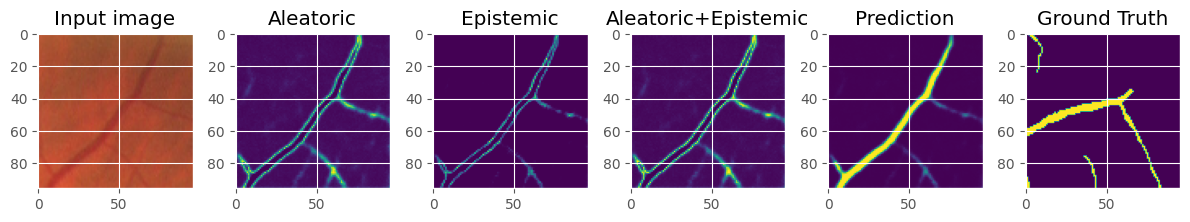

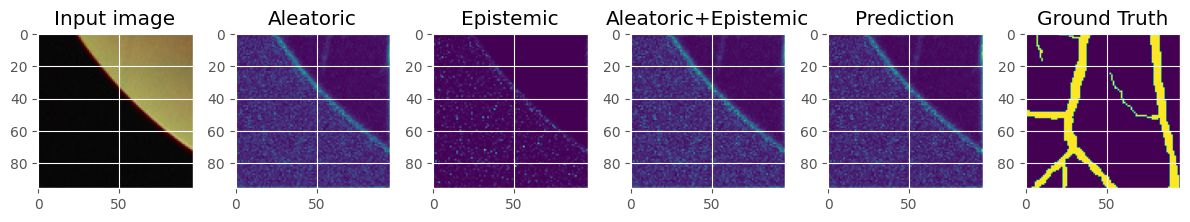

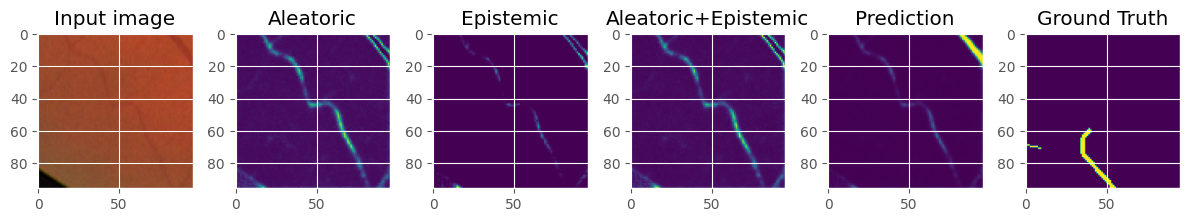

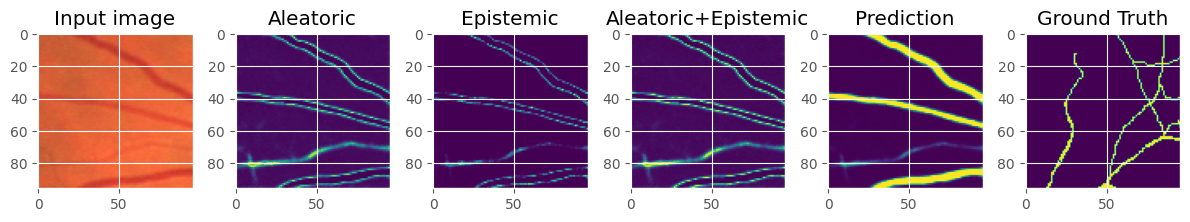

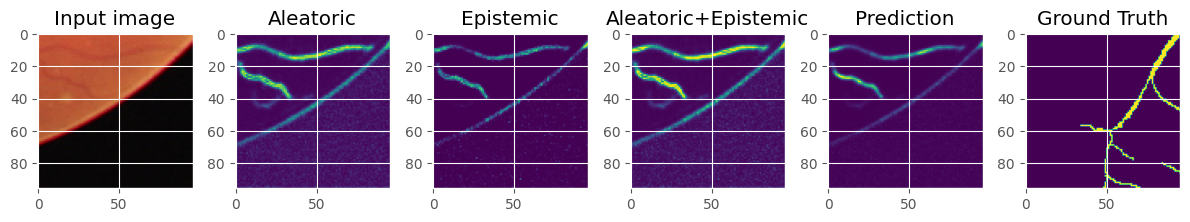

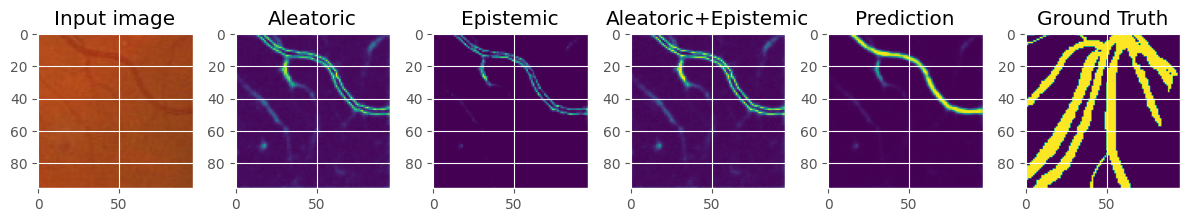

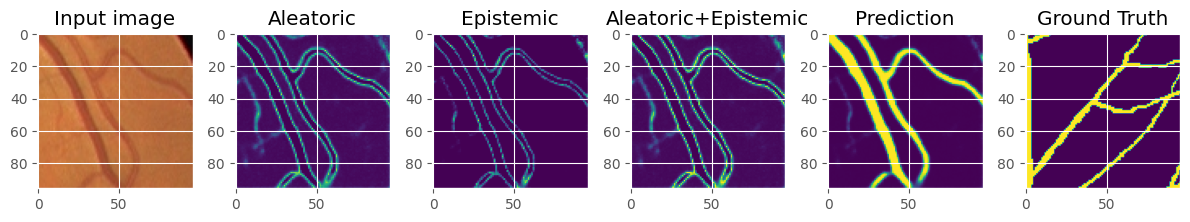

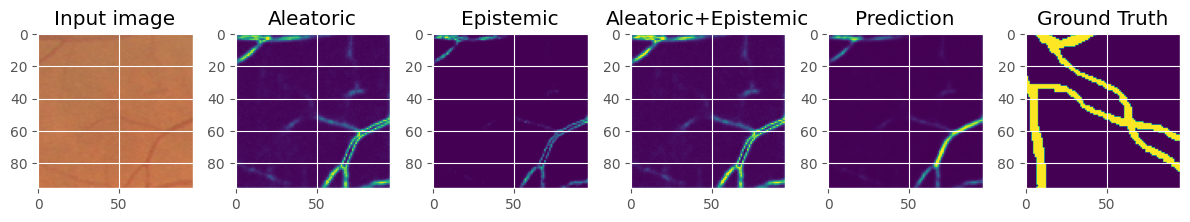

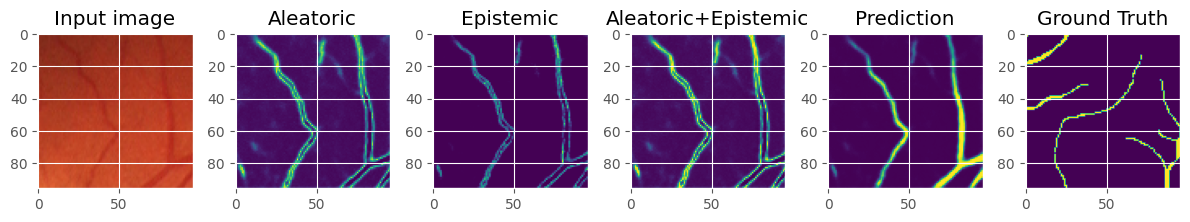

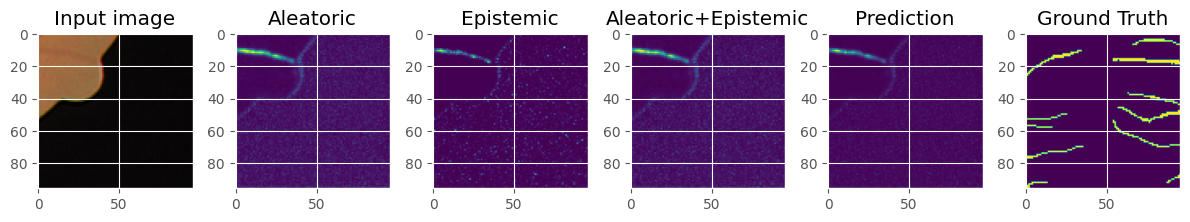

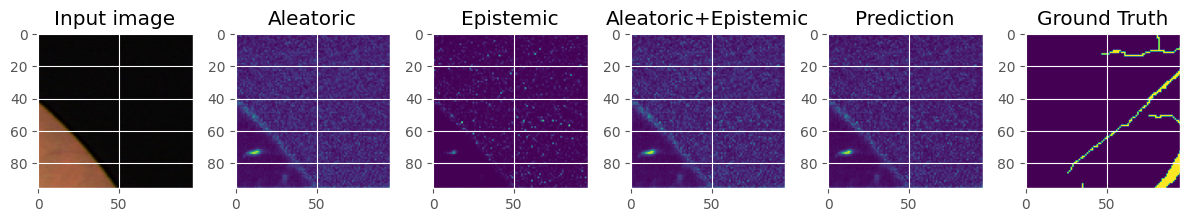

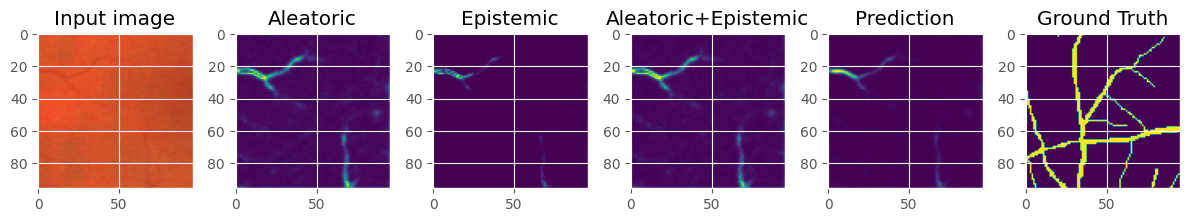

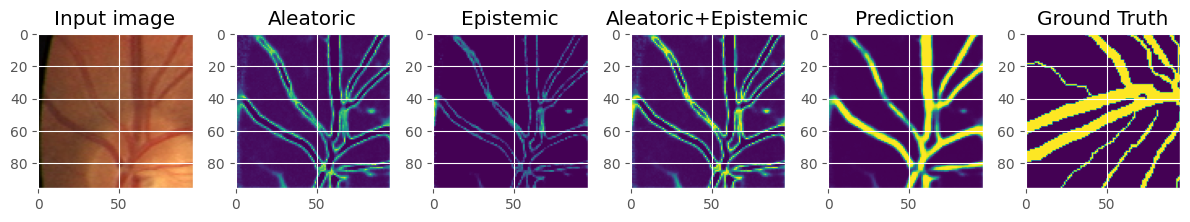

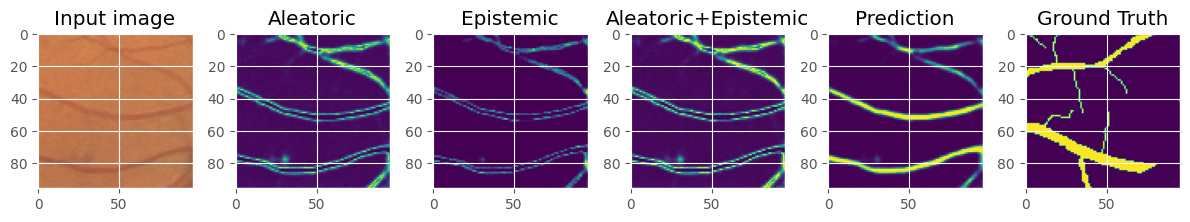

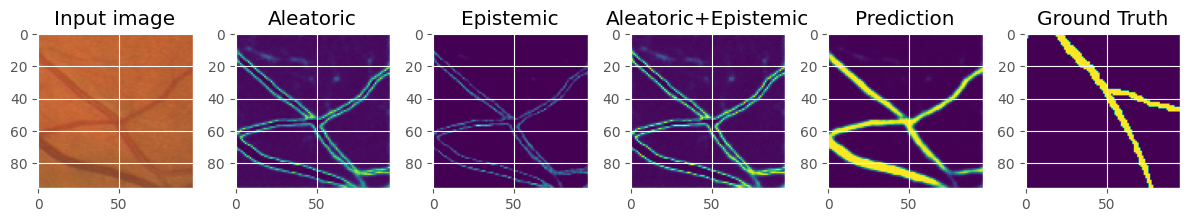

In [127]:
import random

random_num = random.sample(range(0, np.shape(X_test)[0]), 20)
for i in random_num:
    display_all(model, X_test, Y_test, i)